In [1]:
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer graphics
from sklearn.model_selection import train_test_split
#from planet import planet
from planet2 import planet

In [2]:
# Function to split real and imaginary part of complex data into individual element of an array
def split_complex_data(data):
    split_data = np.zeros([data.shape[0],2*data.shape[1]])
    for i in range(data.shape[1]):
        split_data[:,2*i] = data[:,i].real
        split_data[:,2*i+1] = data[:,i].imag
    return split_data

# Function to split testing data according the type of tissue
def split_t2_tissues(data):
    gm_test = []  # T2 = 100 ms
    wm_test = []  # T2 = 80 ms

    for i in range(len(data)):
        if gt_test[i] == 0.1:
            gm_test.append(data[i,:])
        
        if gt_test[i] == 0.08:
            wm_test.append(data[i,:])

    gm_test  = np.asarray(gm_test)
    wm_test  = np.asarray(wm_test)
    return gm_test, wm_test

# Function for Monte Carlo Simulation
def monte_carlo(data):
    pdf = [] #empty list to store probability value
    result = 0

    # Neural network
    if data.shape[1] == 16:
        predicted_t2 = model.predict(data)

    # PLANET
    if data.shape[1] == 8:
        predicted_t2 = []
        TR = 3e-3 # TR = relaxation time
        npcs = 8  # npcs = no. of phase cycles, 
        B0 = 3   # B0 =main magnetic field
        alpha = np.deg2rad(30) # alpha = flip angle
        pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
        count = 0
        for i in range(len(data)):
            #_, _, temp ,_ = planet(data[i,:], alpha=alpha, TR=TR, T1_guess=2, pcs=pcs, compute_df=False)
            _, _, temp ,_ = planet(data[i,:], alpha=alpha, TR=TR, T1_guess=2, pcs=pcs, mask=None, pc_axis=0, ret_all=False)
            if temp > 0.07 and temp < 0.12:
            #if a > 0 and a < 1:
            #if a > 0 and a < 1 and temp > 0.07 and temp < 0.12:
                predicted_t2.append(temp)
            else:
                count = count+1
        
        predicted_t2  = np.asarray(predicted_t2)
        return (predicted_t2.mean(), predicted_t2.std(), predicted_t2, count)

    return (predicted_t2.mean(), predicted_t2.std(), predicted_t2)

In [3]:
# Load voxel and ground truth t2 data
voxel_data = np.load('data/voxel_data.npy')
gt_data = np.load('data/gt_data.npy')

# Train test split
voxel_train, voxel_test, gt_train, gt_test = train_test_split(voxel_data, gt_data, test_size=0.1, random_state=42)

print('Training data:', voxel_train[0,:])
print('Ground Truth T2:', gt_train[0,:])

Training data: [-0.00294712+0.00393944j  0.07440676+0.03623832j  0.08507895+0.08899182j
  0.05099229+0.12522469j -0.00055691+0.13743604j -0.05165864+0.12645276j
 -0.08627049+0.08944335j -0.07667491+0.0367126j ]
Ground Truth T2: [0.1]


In [232]:
new_voxel_train = split_complex_data(voxel_train)
print('Complex voxel data split into real and imaginary parts:')
print(new_voxel_train[0,:])
new_voxel_test = split_complex_data(voxel_test)

Complex voxel data split into real and imaginary parts:
[-0.00294712  0.00393944  0.07440676  0.03623832  0.08507895  0.08899182
  0.05099229  0.12522469 -0.00055691  0.13743604 -0.05165864  0.12645276
 -0.08627049  0.08944335 -0.07667491  0.0367126 ]


In [233]:
# Define the network structure
inputs = tf.keras.Input(shape=(16,)) #number of inputs
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(inputs)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x) # no. of outputs
#outputs=tf.keras.layers.Dense(1, activation=tf.keras.activations.relu, kernel_initializer='normal',bias_initializer=tf.keras.initializers.Constant(0.1))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [234]:
# Define optimizer and train the network

# To save the model for each epoch, uncomment the checkpoint_callback below
# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True mode='auto', save_freq='epoch')

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse', metrics='mse')

start=time.time()

history = model.fit(new_voxel_train, gt_train,epochs=10, batch_size=10, validation_split=0.1)  # starts training

# 2nd set of parameters
# model.fit(voxel_train, gt_train,epochs=100, batch_size=100, validation_data=(voxel_valid,gt_valid),callbacks=[checkpoint_callback])  # starts training

end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/10
8100/8100 [==============================] - 42s 5ms/step - loss: 1.3809e-04 - mse: 1.3809e-04 - val_loss: 2.9973e-05 - val_mse: 2.9973e-05
Epoch 2/10
8100/8100 [==============================] - 44s 5ms/step - loss: 1.0789e-05 - mse: 1.0789e-05 - val_loss: 4.0961e-06 - val_mse: 4.0961e-06
Epoch 3/10
8100/8100 [==============================] - 50s 6ms/step - loss: 6.0404e-06 - mse: 6.0404e-06 - val_loss: 3.9139e-06 - val_mse: 3.9139e-06
Epoch 4/10
8100/8100 [==============================] - 51s 6ms/step - loss: 4.2607e-06 - mse: 4.2607e-06 - val_loss: 1.3895e-06 - val_mse: 1.3895e-06
Epoch 5/10
8100/8100 [==============================] - 46s 6ms/step - loss: 2.9974e-06 - mse: 2.9974e-06 - val_loss: 8.1275e-07 - val_mse: 8.1275e-07
Epoch 6/10
8100/8100 [==============================] - 41s 5ms/step - loss: 2.5885e-06 - mse: 2.5885e-06 - val_loss: 6.5742e-07 - val_mse: 6.5742e-07
Epoch 7/10
8100/8100 [==============================] - 44s 5ms/step - loss: 2.5113e-06 - mse:

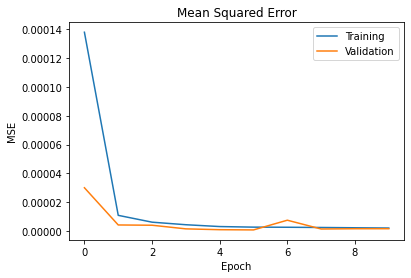

1000/1000 [==============================] - 4s 4ms/step - loss: 1.2451e-06 - mse: 1.2451e-06
Test MSE:0.000001


In [235]:
# MSE for each epoch during training
#print(model.summary())
#print(history.history.keys())
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Evaluate model using testing set
test_metric = model.evaluate(new_voxel_test, gt_test, batch_size=10)
print('Test MSE:%.6f'%test_metric[1])

In [236]:
# Save or load trained model 
#model.save('voxel_regression'); 
#model = tf.keras.models.load_model('voxel_regression')

In [237]:
# Split testing data into corresponding tissues
gm_test, wm_test = split_t2_tissues(voxel_test)
new_gm_test, new_wm_test = split_t2_tissues(new_voxel_test)

In [238]:
# PLANET : Monte Carlo
#mean_gm_t2_p, std_gm_t2_p, gm_pdf_p = monte_carlo(gm_test)
mean_gm_t2_p, std_gm_t2_p, gm_pdf_p, count_failed_gm = monte_carlo(gm_test)
print('Rejected %d out of %d' %(count_failed_gm,len(gm_test)))
print('PLANET Mean T2 (GM):', mean_gm_t2_p)
#mean_wm_t2_p, std_wm_t2_p, wm_pdf_p = monte_carlo(wm_test)
mean_wm_t2_p, std_wm_t2_p, wm_pdf_p, count_failed_wm = monte_carlo(wm_test)
print('Rejected %d out of %d' %(count_failed_wm,len(wm_test)))
print('PLANET Mean T2 (WM):', mean_wm_t2_p)

Rejected 995 out of 5198
PLANET Mean T2 (GM): 0.09640899003874866
Rejected 660 out of 4802
PLANET Mean T2 (WM): 0.08362392387216083


In [239]:
# Neural network : Monte Carlo
mean_gm_t2, std_gm_t2, gm_pdf = monte_carlo(new_gm_test)
mean_wm_t2, std_wm_t2, wm_pdf = monte_carlo(new_wm_test)

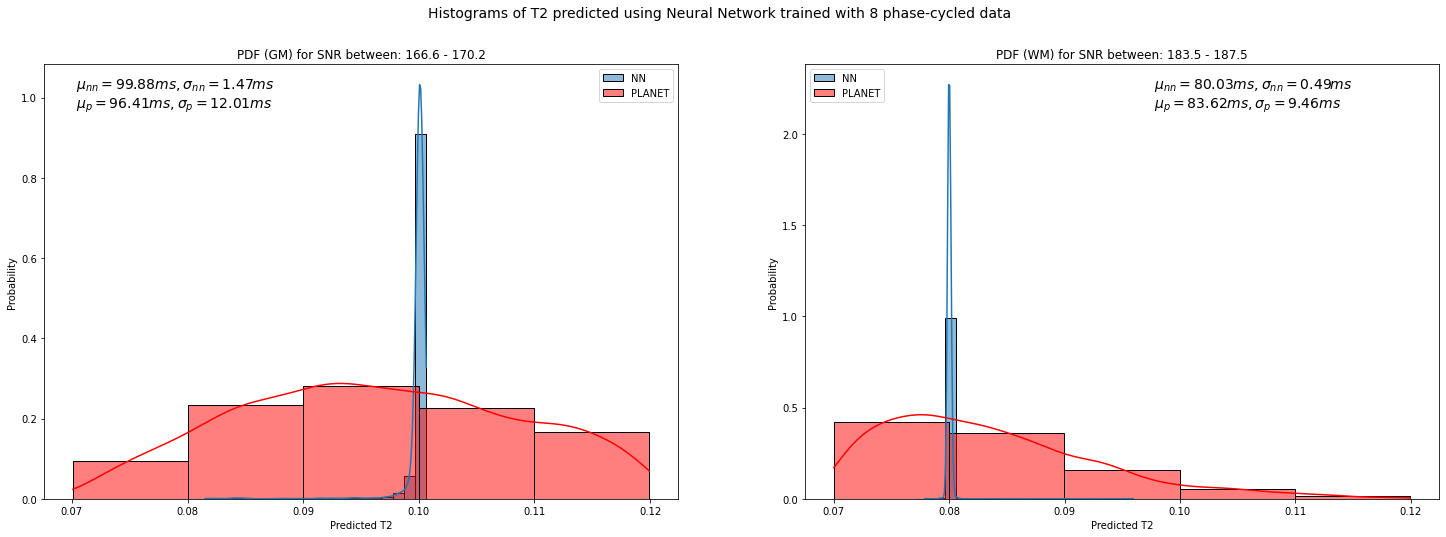

In [240]:
# Histograms
# Parameters for histograms plotting
snr_data = np.load('data/snr_data.npy')
s = '\n'
gm_str = s.join(['$\mu_{nn} = %.2f ms, \sigma_{nn} = %.2f ms$'%(mean_gm_t2*1000,std_gm_t2*1000), '$\mu_{p}  = %.2f ms, \sigma_{p}  = %.2f ms$'%(mean_gm_t2_p*1000,std_gm_t2_p*1000)])
wm_str = s.join(['$\mu_{nn} = %.2f ms, \sigma_{nn}  = %.2f ms$'%(mean_wm_t2*1000,std_wm_t2*1000), '$\mu_{p}  = %.2f ms, \sigma_{p}  = %.2f ms$'%(mean_wm_t2_p*1000,std_wm_t2_p*1000)])
textbox_height = 0.9
textbox_width  = 0.55
fs = 14
bins = 20
bins_p = 5

# Plotting of histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 8))
fig.suptitle('Histograms of T2 predicted using Neural Network trained with 8 phase-cycled data',fontsize=14)

# GM
sns.histplot(data=gm_pdf, bins=bins, stat='probability', legend=False, label='NN', kde=True, ax=ax1)
sns.histplot(data=gm_pdf_p, bins=bins_p, stat='probability', legend=False, kde=True, label='PLANET',color='r', ax=ax1)
ax1.set_title('PDF (GM) for SNR between: %.1f - %.1f'%(snr_data[0],snr_data[1]))
ax1.text(textbox_width-0.5, textbox_height,gm_str,fontsize=fs,transform=ax1.transAxes)
ax1.set_xlabel('Predicted T2')
ax1.set_ylabel('Probability')
ax1.legend()
# WM
sns.histplot(data=wm_pdf, bins=bins, stat='probability', legend=False, label='NN', kde=True, ax=ax2)
sns.histplot(data=wm_pdf_p, bins=bins_p, stat='probability', legend=False, kde=True, label='PLANET',color='r', ax=ax2)
ax2.set_title('PDF (WM) for SNR between: %.1f - %.1f'%(snr_data[2],snr_data[3]))
ax2.text(textbox_width, textbox_height,wm_str,fontsize=fs,transform=ax2.transAxes)
ax2.set_xlabel('Predicted T2')
ax2.set_ylabel('Probability')
ax2.legend(loc='upper left')